**Background**:

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (desired target):**

y - has the client subscribed to a term deposit? (binary)

In [1]:
!pip uninstall pycaret[full] -y

Found existing installation: pycaret 3.0.2
Uninstalling pycaret-3.0.2:
  Successfully uninstalled pycaret-3.0.2


In [2]:
!pip install lazypredict
!pip install shap
!pip install pycaret
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycaret-3.0.2-py3-none-any.whl (483 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
import xgboost as xgb
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import confusion_matrix
from pycaret.classification import *


np.random.seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv(r"/content/drive/MyDrive/Aprziva/second_project/term-deposit-marketing-2020.csv")

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [7]:
df.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


In [8]:
df.info

<bound method DataFrame.info of        age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  da

In [9]:
column_types = df.dtypes
column_types

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [10]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [11]:
target_counts = df['y'].value_counts()
class_balance = target_counts / len(df) * 100
target_counts
#class_balance

no     37104
yes     2896
Name: y, dtype: int64

The dat seems to be imbalanced...

In [12]:
X = df.drop('y', axis=1)
Y = df['y']

In [13]:
numeric_df = X.select_dtypes(include=['int64']).copy()
cols = numeric_df.columns
numeric_features = list(cols)
numeric_features


['age', 'balance', 'day', 'duration', 'campaign']

In [14]:
categorical_df = X.select_dtypes(include=['object']).copy()
cols = categorical_df.columns
categorical_features = list(cols)
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month']

In [15]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1


# Analysis of numerical data

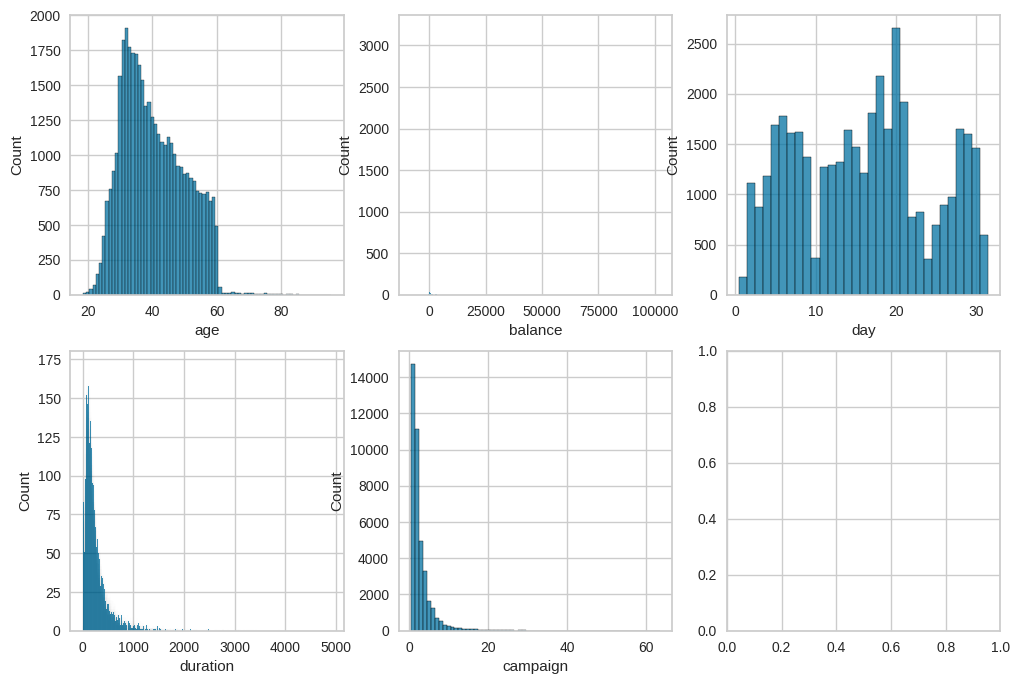

In [16]:
fig, ax = plt.subplots(2,3,figsize=(12, 8))
i = 0
for items in numeric_df.columns[:5]:
  sns.histplot(data=numeric_df, x=items, ax=ax[i // 3, i % 3], discrete=True)
  i += 1


In [17]:
imputer = SimpleImputer(strategy="median")

imp_numeric_df = imputer.fit_transform(numeric_df)

scaler = StandardScaler()

scaled_numeric_df = scaler.fit_transform(imp_numeric_df)

X_categorical_encoded_df = pd.DataFrame(scaled_numeric_df, columns=numeric_features)

X_categorical_encoded_df


,age,balance,day,duration,campaign
0,1.81,0.30,-1.33,0.02,-0.58
1,0.36,-0.43,-1.33,-0.40,-0.58
2,-0.78,-0.44,-1.33,-0.69,-0.58
3,0.67,0.08,-1.33,-0.63,-0.58
4,-0.78,-0.44,-1.33,-0.22,-0.58
...,...,...,...,...,...
39995,1.29,-0.30,-1.57,-0.57,-0.58
39996,-1.09,0.71,-1.57,-0.06,0.04
39997,1.40,-0.37,-1.57,-0.33,-0.58
39998,-0.68,-0.08,-1.57,0.34,-0.58


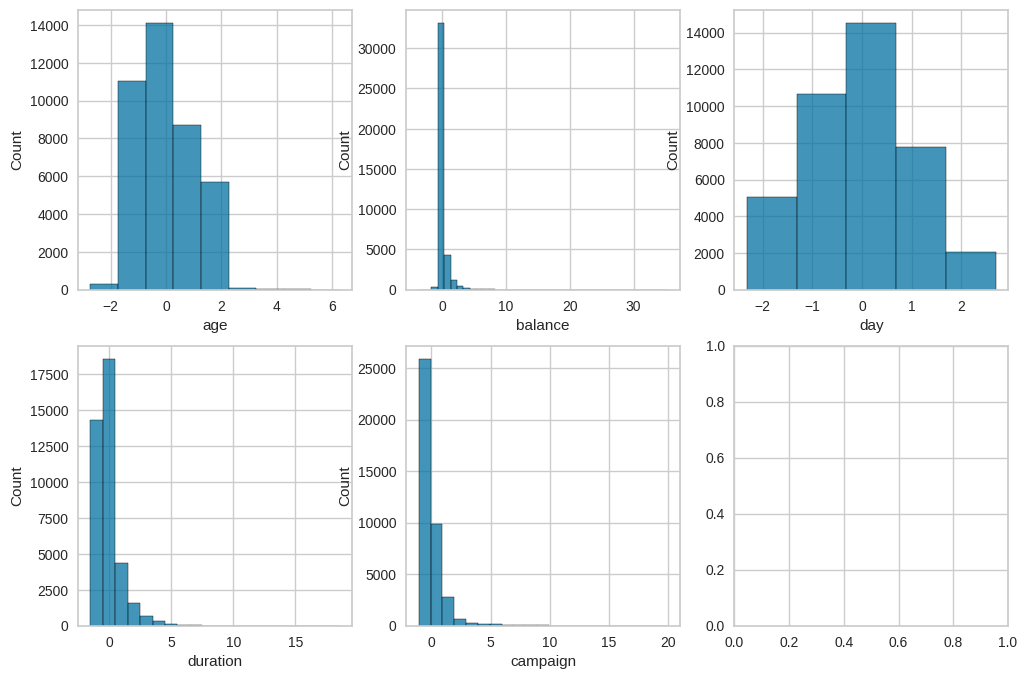

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i, item in enumerate(numeric_df.columns[:5]):
    if i < 5:
        sns.histplot(data=X_categorical_encoded_df, x=item, ax=ax[i // 3, i % 3], discrete=True)
    else:
        ax[i // 3, i % 3].axis("off")


# Transform target variable to numerical ones

In [19]:
transformer = LabelEncoder()

Y = transformer.fit_transform(Y.values)
Y

array([0, 0, 0, ..., 1, 0, 0])

# Build a pipiline for the preprocessing and model    

In [20]:
from imblearn.over_sampling import SMOTE

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
        ("selector", SelectPercentile(chi2, percentile=95)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=95,
                                                                                    score_func=<function chi2 at 0x7f34931c8790>))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month'])])),
                ('classifier', LogisticRegression())])

model score: 0.934
Model: Logistic Regression
Trained data accuracy: 0.9351
Test data accuracy: 0.9345
Precision: 0.6078
Recall: 0.2677
F1 Score: 0.3717
ROC AUC Score: 0.9286
---


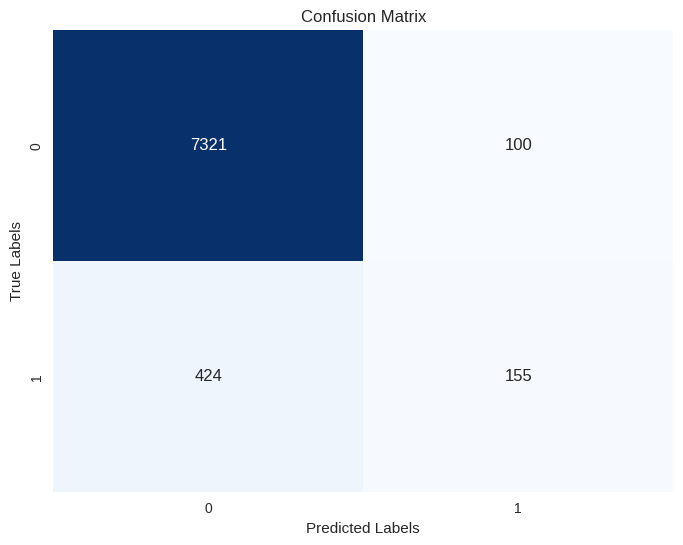

In [21]:


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

model = clf.fit(X_train, y_train)


print("model score: %.3f" % clf.score(X_test, y_test))

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred1 = model.predict(X_train)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Model: Logistic Regression')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')

# Assuming you have the true labels 'y_true' and the predicted labels 'y_pred'
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Display the plot
plt.show()

In [22]:
clf1 = setup(X, target = Y, session_id=786)

,Description,Value
0,Session id,786
1,Target,target
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(40000, 42)"
5,Transformed train set shape,"(28000, 42)"
6,Transformed test set shape,"(12000, 42)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,8


In [23]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9372,0.9433,0.3547,0.6157,0.4492,0.4185,0.4369,0.3160
lightgbm,Light Gradient Boosting Machine,0.9363,0.9493,0.4070,0.5883,0.4802,0.4476,0.4567,0.3830
rf,Random Forest Classifier,0.9354,0.9377,0.2995,0.6130,0.4013,0.3715,0.3988,0.5190
xgboost,Extreme Gradient Boosting,0.9344,0.9453,0.4050,0.5670,0.4719,0.4381,0.4454,0.2540
lr,Logistic Regression,0.9340,0.9217,0.2610,0.6027,0.3634,0.3344,0.3676,0.6400
lda,Linear Discriminant Analysis,0.9329,0.9281,0.4238,0.5484,0.4775,0.4423,0.4468,0.2400
et,Extra Trees Classifier,0.9329,0.9222,0.2442,0.5885,0.3440,0.3151,0.3498,0.9370
ridge,Ridge Classifier,0.9317,0.0000,0.1436,0.6243,0.2329,0.2117,0.2766,0.2480
ada,Ada Boost Classifier,0.9300,0.9287,0.3108,0.5309,0.3910,0.3566,0.3716,0.6060
dummy,Dummy Classifier,0.9276,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2310


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=786, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

The model has a very good accuracy, but in case of a imbalanced data it make more sense to look at the F1 parameter which combines precision and recall. F1 of 50% is not a good result of a model and data augmentation should be used.

In [24]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9404,0.9549,0.3663,0.6549,0.4698,0.4409,0.4619
1,0.9336,0.9337,0.2426,0.5976,0.3451,0.3166,0.3527
2,0.9386,0.9404,0.3069,0.6596,0.4189,0.3910,0.4232
3,0.9296,0.9313,0.3153,0.5246,0.3938,0.3590,0.3721
4,0.9396,0.9303,0.3054,0.6889,0.4232,0.3963,0.4332
5,0.9296,0.9271,0.2709,0.5288,0.3583,0.3252,0.3456
6,0.9389,0.9437,0.3251,0.6600,0.4356,0.4073,0.4360
7,0.9354,0.9355,0.2759,0.6222,0.3823,0.3535,0.3863
8,0.9379,0.9437,0.3103,0.6495,0.4200,0.3915,0.4215


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

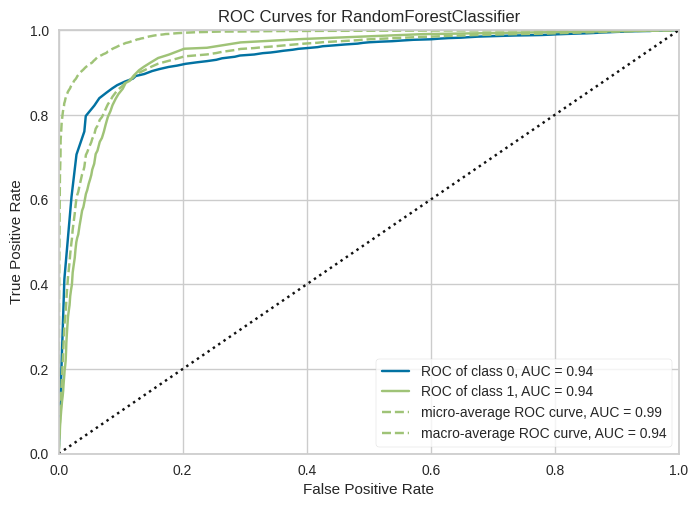

In [25]:
plot_model(rf)

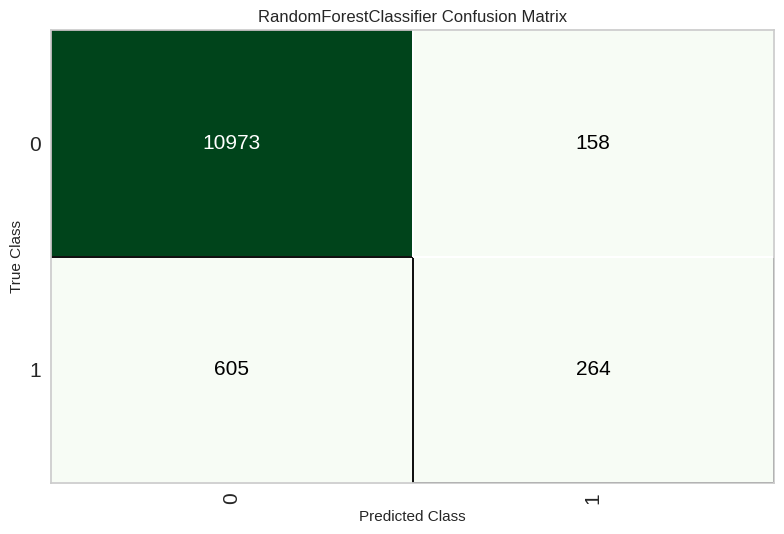

In [26]:
plot_model(rf, plot = 'confusion_matrix')

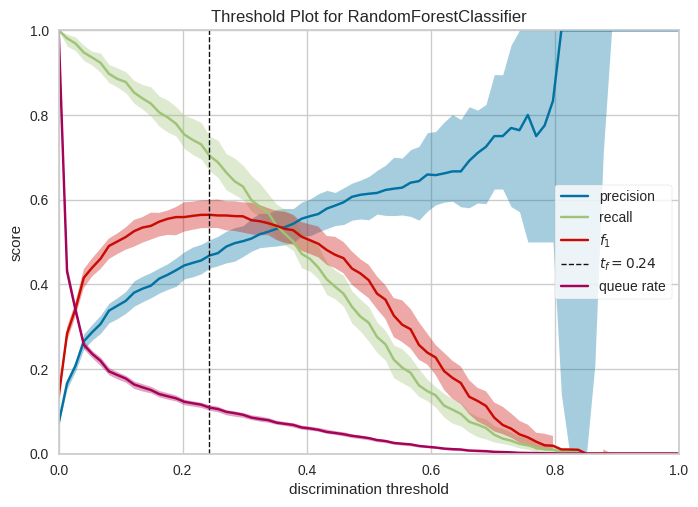

In [27]:
plot_model(rf, plot = 'threshold')

# Preprocess for SMOTE

In [28]:

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Apply one-hot encoding to the categorical features
X_categorical_encoded = encoder.fit_transform(categorical_df).toarray()

# Get the feature names for the encoded categorical features
categorical_feature_names = encoder.get_feature_names_out(input_features=categorical_features)

# Create a DataFrame for the encoded categorical features
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=categorical_feature_names)

X_encoded = pd.concat([numeric_df, X_categorical_encoded_df], axis=1)


In [29]:
from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE class
smote = SMOTE(random_state=0)

# Resample the dataset using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_encoded, Y)

# Count the class distribution before applying SMOTE
unique_classes, class_counts = np.unique(Y, return_counts=True)
print("Class distribution before SMOTE:", dict(zip(unique_classes, class_counts)))

# Count the class distribution after applying SMOTE
unique_classes_resampled, class_counts_resampled = np.unique(y_resampled, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique_classes_resampled, class_counts_resampled)))




Class distribution before SMOTE: {0: 37104, 1: 2896}
Class distribution after SMOTE: {0: 37104, 1: 37104}


In [30]:
from imblearn.over_sampling import SMOTE

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("selector", SelectPercentile(chi2, percentile=95)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('scale...
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

model score: 0.796
Model: Logistic Regression
Trained data accuracy: 0.7956
Test data accuracy: 0.7961
Precision: 0.8308
Recall: 0.7436
F1 Score: 0.7848
ROC AUC Score: 0.8776
---


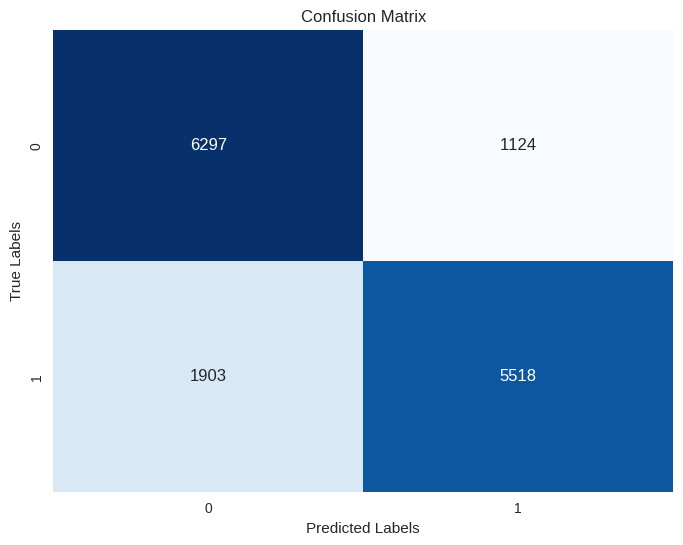

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0, stratify=y_resampled)

model = clf.fit(X_train, y_train)

print("model score: %.3f" % clf.score(X_test, y_test))

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred1 = model.predict(X_train)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Model: Logistic Regression')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')

# Assuming you have the true labels 'y_true' and the predicted labels 'y_pred'
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Display the plot
plt.show()

In [32]:
clf2 = setup(X_resampled, target = y_resampled, session_id=786)

,Description,Value
0,Session id,786
1,Target,target
2,Target type,Binary
3,Original data shape,"(74208, 45)"
4,Transformed data shape,"(74208, 45)"
5,Transformed train set shape,"(51945, 45)"
6,Transformed test set shape,"(22263, 45)"
7,Numeric features,44
8,Preprocess,True
9,Imputation type,simple


In [33]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9675,0.9957,0.9553,0.9793,0.9671,0.9351,0.9354,2.0710
lightgbm,Light Gradient Boosting Machine,0.9665,0.9962,0.9581,0.9746,0.9662,0.9330,0.9332,0.3380
rf,Random Forest Classifier,0.9663,0.9958,0.9506,0.9816,0.9658,0.9327,0.9332,1.0000
xgboost,Extreme Gradient Boosting,0.9657,0.9960,0.9580,0.9730,0.9654,0.9314,0.9315,0.2890
gbc,Gradient Boosting Classifier,0.9602,0.9948,0.9544,0.9656,0.9600,0.9204,0.9205,0.3060
dt,Decision Tree Classifier,0.9534,0.9534,0.9551,0.9518,0.9534,0.9067,0.9067,0.2280
ada,Ada Boost Classifier,0.9517,0.9921,0.9437,0.9592,0.9513,0.9035,0.9036,0.3550
knn,K Neighbors Classifier,0.8818,0.9404,0.9550,0.8332,0.8899,0.7637,0.7720,4.2770
lr,Logistic Regression,0.8723,0.9365,0.8818,0.8655,0.8735,0.7447,0.7449,0.2960
ridge,Ridge Classifier,0.8655,0.0000,0.8547,0.8735,0.8640,0.7309,0.7311,0.2000


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=786, verbose=0, warm_start=False)

In [34]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9705,0.9964,0.9573,0.9834,0.9702,0.9411,0.9414
1,0.9669,0.9958,0.9577,0.9757,0.9666,0.9338,0.9339
2,0.9688,0.9957,0.9596,0.9776,0.9685,0.9376,0.9378
3,0.9661,0.9946,0.9538,0.9779,0.9657,0.9322,0.9325
4,0.9623,0.9950,0.9480,0.9758,0.9617,0.9245,0.9249
5,0.9669,0.9955,0.9557,0.9776,0.9665,0.9338,0.9340
6,0.9711,0.9962,0.9626,0.9792,0.9709,0.9422,0.9424
7,0.9667,0.9968,0.9488,0.9840,0.9661,0.9334,0.9340
8,0.9661,0.9954,0.9526,0.9790,0.9657,0.9322,0.9326


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

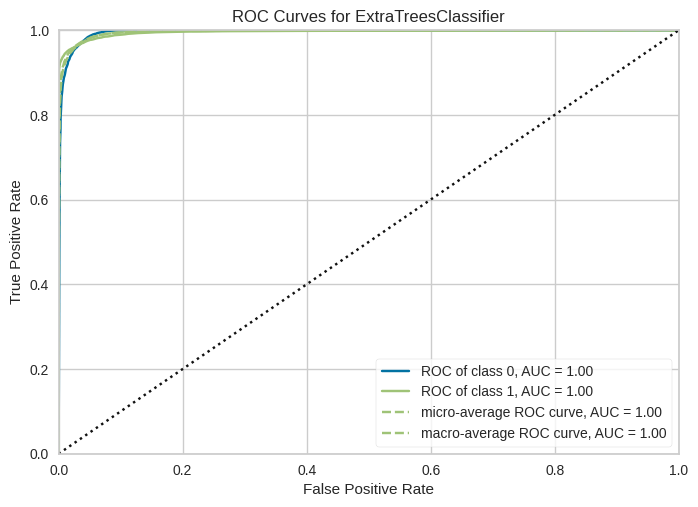

In [35]:
plot_model(et)

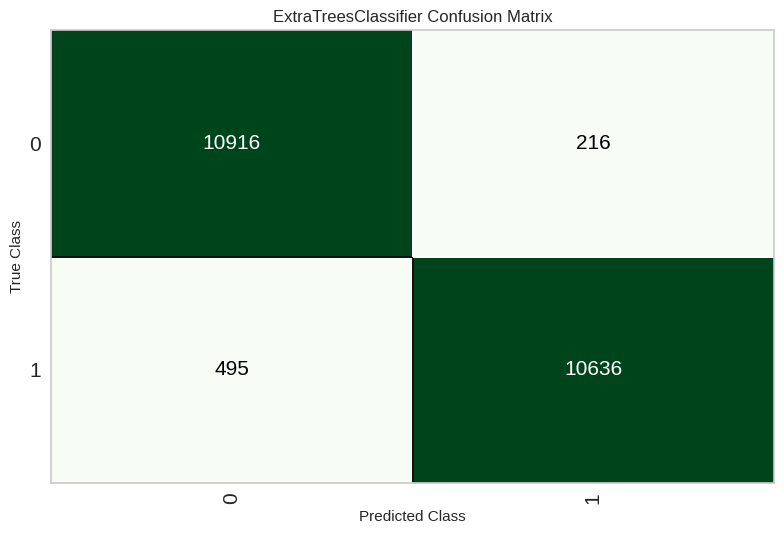

In [36]:
plot_model(et, plot = 'confusion_matrix')

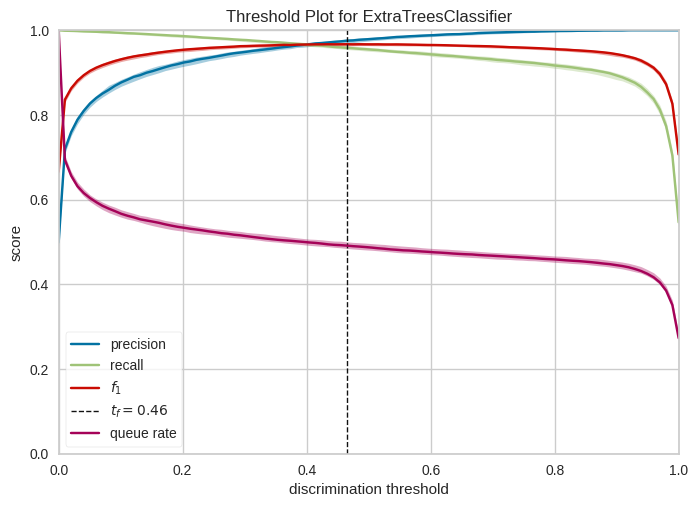

In [37]:
plot_model(et, plot = 'threshold')

Feature ranking:
1. Feature duration (0.1727884686132782)
2. Feature contact_cellular (0.05752639609286048)
3. Feature contact_unknown (0.050143149114059204)
4. Feature marital_married (0.04979520296468681)
5. Feature education_secondary (0.04495802130720161)
6. Feature housing_yes (0.04479486465679849)
7. Feature housing_no (0.0431570121853596)
8. Feature marital_single (0.03980768438223347)
9. Feature month_may (0.03968375950596176)
10. Feature education_tertiary (0.036929607434858173)
11. Feature month_apr (0.03302749609221155)
12. Feature job_blue-collar (0.0292683473174062)
13. Feature month_aug (0.02598810685289834)


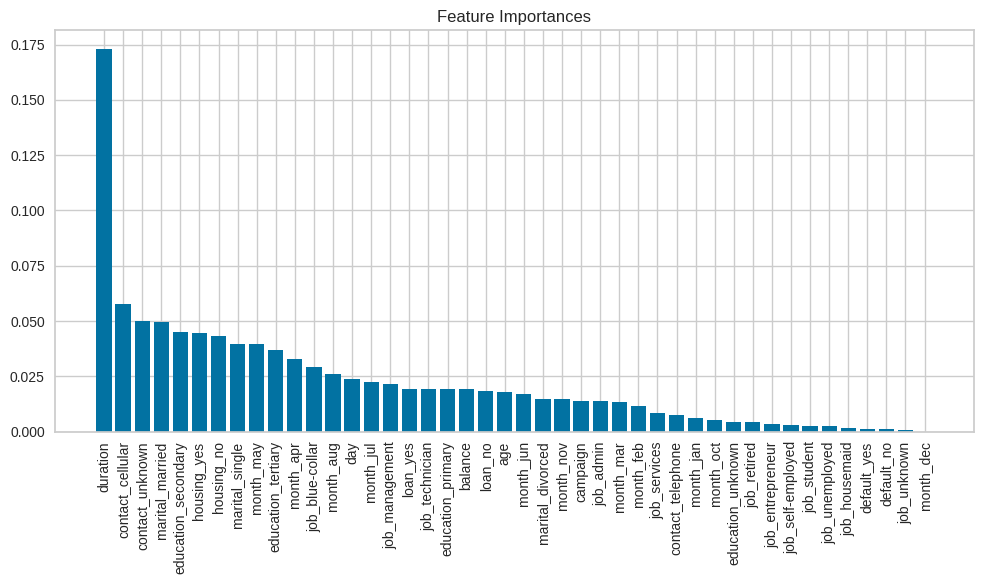

In [38]:
# Retrieve the feature importances from the trained model
importances = et.feature_importances_

# Sort the importances in descending order and get the corresponding feature indices
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X_resampled.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances using a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_resampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_resampled.shape[1]), X_resampled.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

* We can see that the most important feature is how long the customer is in contact with the company. 

* It's important to contact the customers, otherwise they probably won't take any action on their own.

* People with secondary education are also slighlty more likely subscribe than the people with tertiary education. 

* House loan seems not to have a great influence on the subscription.

* On the other hand, the most likely group to buy the subscription is connnected with the blue collar jobs.

* Married people are slightly more likely to get involved than the single people.

* On the other hand the customer is most likely to make any purchase during the spring/summer months from April to August. 

* Other features have relatively lower influence.